# Finite-size scaling and critical exponents

The two-dimensional Ising model consists of $NxN$ spins arranged on a square lattice. Each spin can take the values $s_i\in\{-1,+1\}$. The energy $\mathcal{H}$ in abscence of a magnetic field is given by

$$ \mathcal{H}=-J\sum_{<ij>}s_is_j, $$

where $<ij>$ indicates nearest-neighbour pairs. To avoid boundary effects, periodic boundary conditions are employed.

---

In order to make the code more efficient, we first generate a *look-up table* containing all of the possible energy differences available. This way we do not need to calculate the quantity $\min[1,\exp(-\beta\Delta E)]$ every time we attempt a spin flip. Instead, we look for the energy difference corresponding to that spin flip in a list of precomputed values.

In [1]:
function ΔE_LookUpTable(nnSum::Int64, J::Int64, β::Float64)
    """ Look up table of possible energy differences
    nnSum = ∑s*sneighbour, the possibilities available are (-4, -2, 0, 2, 4)
    J     = coupling constant
    β     = inverse temperature
    
    return min(1, exp(-βΔE))
    """
    table = Dict(-4=>1, -2=>1, 0=>1, +2=>exp(-4.0*J*β), +4=>exp(-8.0*J*β))
    
    return table[nnSum]
end;

Now we define a function that evolves the system by employing the following procedure:

1. Pick a spin $s_i$ from the configuration
2. Calculate the energy difference $\Delta{E}$ between the new and previous configuration
3. Pick a random number $r\in(0,1)$
4. Accept the move only if $r<\min(1,e^{-\Delta E/k_BT})$
5. Perform steps 1-4 for each spin in the lattice, i.e. we "sweep" the system once
6. Perform N sweeps; record the value of the magnetization at each sweep

In [2]:
function evolve_M(nsweeps::Int64, spin_lattice::Matrix{Int64}, J::Int64, β::Float64)
    """ Generate M(t) using importance sampling
    nsweeps      = number of sweeps, i.e. Monte Carlo steps per spin
    spin_lattice = initial square lattice
    β            = inverse temperature
    J            = neighbour spins coupling constant
    
    return M(t)
    """
    # Initialize variables
    nspins  = size(spin_lattice, 1)                     # number of spins
    m_t_vec = zeros(Float64, nsweeps)                   # empty array M(t) of size nsweeps
    prev_vec = [s==1 ? s=nspins : s-1 for s ∈ 1:nspins] # Array (1,2,..,nspins) with periodic condition 1=nspins
    next_vec = [s==nspins ? s=1 : s+1 for s ∈ 1:nspins] # Array (1,2,..,nspins) with periodic condition nspins=1

    # Record initial configuration
    m_t_vec[1] = sum(spin_lattice)
    
    # Evolve the system
    ## perform nsweeps-1 sweeps
    for sweep ∈ 2:nsweeps
        
        ## sweep over the lattice
        for i ∈ 1:nspins
            for j ∈ 1:nspins
                ## choose spin and get neighbours
                s = spin_lattice[i,j]
                nn_right = spin_lattice[next_vec[i], j]
                nn_left = spin_lattice[prev_vec[i], j]
                nn_up = spin_lattice[i, next_vec[j]]
                nn_down = spin_lattice[i, prev_vec[j]]
                nnSum = s*(nn_right + nn_left + nn_up + nn_down)

                ## get random number r, and energy difference ΔE from the look-up table
                r = rand()
                ΔE = ΔE_LookUpTable(nnSum, J, β)
                
                ## accept or reject move
                if r < ΔE
                    spin_lattice[i,j] = -s
                end
            end
        end
        
        ## store results
        m_t_vec[sweep] = sum(spin_lattice)
        
    end
    
    return m_t_vec
end;

In [3]:
function average_M(nspins::Int64, nsteps::Int64, β_vec::Vector{Float64}, J::Int64, tcutoff::Int64)
    """ Get average values of M(t) at given β
    nspins  = number of spins
    nsteps  = number of sweeps
    β_vec   = array of inverse temperatures 1/kT
    J       = coupling constant
    tcutoff = number of sweeps cutoff
    
    return ( <M>, <M^2>, <M^4> )
    """
    # initial lattice of size (nspins)x(nspins) filled with ones
    spin_lattice = ones(Int64,nspins,nspins)
    
    # Initialize variables
    nsamples     = 0                            # number of samples
    mav_vec      = zeros(Float64,length(β_vec)) # empty array <M>
    m2av_vec     = zeros(Float64,length(β_vec)) # empty array <M^2>
    m4av_vec     = zeros(Float64,length(β_vec)) # empty array <M^4>
    
    # Iterate over β_vec
    for (i,β) ∈ enumerate(β_vec)
        
        # get time evolution M(t)
        mt_vec = evolve_M(nsteps, spin_lattice, J, β)
        
        # discard transient configurations
        mt_vec_cutoff = mt_vec[tcutoff:nspins:nsteps]
        
        # accumulate results
        mabs = abs.(mt_vec_cutoff)
        m2abs = mabs.^2
        mav_vec[i] = sum(mabs)
        m2av_vec[i] = sum(m2abs)
        m4av_vec[i] = sum(m2abs.^2)
        nsamples = length(mt_vec_cutoff)
    end
    
    # Normalize
    mav_vec /= nsamples
    m2av_vec /= nsamples
    m4av_vec /= nsamples
    
    return (av=mav_vec, av2=m2av_vec, av4=m4av_vec)
end;

---

Then we choose parameters, perform the simulation by calling `evolve_M`, and plot the results

In [4]:
nspins  = 50  # number of spins
nsweeps = 1000 # number of sweeps, i.e. Monte Carlo stepsχ spin
J       = 1    # coupling constant
βcold   = 0.55  # inverse temperature of a "cold" system
βcrit   = 0.43 # inverse temperature of a system close to the critical point
βhot    = 0.34  # inverse temperature of a "hot" system

lattice_cold = ones(Int64, nspins, nspins)               # lattice of size (nspins)x(nspins) filled with ones
m_t_cold     = evolve_M(nsweeps, lattice_cold, J, βcold) # get the magnetization time evolution for the "cold" system
lattice_crit = ones(Int64, nspins, nspins)               # lattice of size (nspins)x(nspins) filled with ones
m_t_crit     = evolve_M(nsweeps, lattice_crit, J, βcrit) # get the magnetization time evolution for the "hot" system
lattice_hot  = ones(Int64, nspins, nspins)               # lattice of size (nspins)x(nspins) filled with ones
m_t_hot      = evolve_M(nsweeps, lattice_hot, J, βhot);  # get the magnetization time evolution for the "hot" system

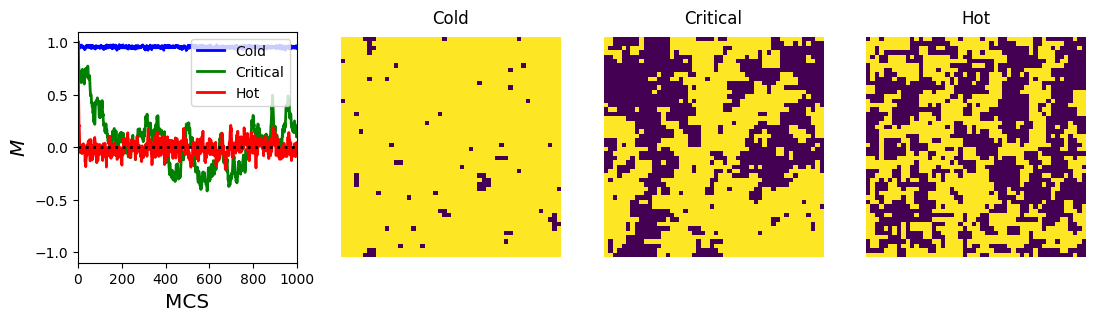

In [5]:
using PyPlot
PyPlot.rc("figure", figsize = (13,3))

step_vec = collect(1:nsweeps)

subplot(141)
plot(step_vec, m_t_cold/nspins^2, lw=2, c="b", label="Cold")
plot(step_vec, m_t_crit/nspins^2, lw=2, c="g", label="Critical")
plot(step_vec, m_t_hot/nspins^2, lw=2, c="r", label="Hot")
plot(step_vec, zeros(length(step_vec)), ls=":", lw=2, c="k")
legend(loc="upper right")

xlim(0, last(step_vec))
ylim(-1.1, 1.1)
xlabel("MCS", size="x-large")
ylabel(L"M", size="x-large")

subplot(142)
title("Cold")
imshow(lattice_cold)
axis("equal")
axis("off")

subplot(143)
title("Critical")
imshow(lattice_crit)
axis("equal")
axis("off")

subplot(144)
title("Hot")
imshow(lattice_hot)
axis("equal")
axis("off");

To calculate the magnetic susceptibility (per spin) from the Monte Carlo simulation we use
$$ \chi = \frac{\beta}{N^2}[\langle M^2\rangle - \langle M\rangle^2]. $$


In order to determine the critical temperature $T_c$ we calculate the *Binder cummulant*,
$$ U_L = 1 - \frac{\langle M^4\rangle}{3\langle M^2\rangle^2}. $$


In [13]:
# set parameters
nsteps  = 50000 # number of MCS
tcutoff = 500  # transient cutoff
J       = 1    # coupling constant

# get averages
kT_crit = 2.0/log(1.0 + sqrt(2.0))
kT_vec  = [0.8, 0.85, 0.9, 0.925, 0.950, 0.975, 1.0, 1.025, 1.05, 1.1, 1.15, 1.20, 1.25, 1.30]*kT_crit
β_vec   = [1.0/kT for kT ∈ kT_vec]
L_vec   = [5, 8, 10, 20, 30, 50]
M_L_vec = []
for L ∈ L_vec
    M_L = average_M(L, nsteps, β_vec, J, tcutoff)
    push!(M_L_vec, M_L)
end

In [14]:
# get magnetization per spin
m_L_vec = []
for (i,M) in enumerate(M_L_vec)
    m = M.av ./ L_vec[i].^2
    push!(m_L_vec, m)
end

# get magnetic susceptibility
χ_L_vec = []
for (i,M) in enumerate(M_L_vec)
    χ = β_vec .* (M.av2 - M.av.^2) ./ L_vec[i].^2
    push!(χ_L_vec, χ)
end

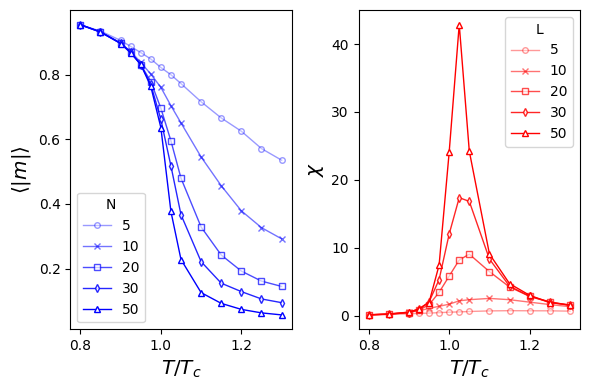

In [15]:
marker_list = ["o", "x", "s", "d", "^"]
alpha_list = [0.4, 0.55, 0.7, 0.85, 1.0]

PyPlot.rc("figure", figsize = (6,4))

subplot(121)
plot(kT_vec/kT_crit, m_L_vec[1], lw=1, label=L_vec[1], c="b", marker=marker_list[1], ms=4, mfc="w", mec="b", alpha=alpha_list[1])
plot(kT_vec/kT_crit, m_L_vec[3], lw=1, label=L_vec[3], c="b", marker=marker_list[2], ms=4, mfc="w", mec="b", alpha=alpha_list[2])
plot(kT_vec/kT_crit, m_L_vec[4], lw=1, label=L_vec[4], c="b", marker=marker_list[3], ms=4, mfc="w", mec="b", alpha=alpha_list[3])
plot(kT_vec/kT_crit, m_L_vec[5], lw=1, label=L_vec[5], c="b", marker=marker_list[4], ms=4, mfc="w", mec="b", alpha=alpha_list[4])
plot(kT_vec/kT_crit, m_L_vec[6], lw=1, label=L_vec[6], c="b", marker=marker_list[5], ms=4, mfc="w", mec="b", alpha=alpha_list[5])

xlabel(L"T/T_c", size="x-large")
ylabel(L"\langle |m| \rangle", size="x-large")
legend(title="N")


subplot(122)
plot(kT_vec/kT_crit, χ_L_vec[1], lw=1, label=L_vec[1], c="r", marker=marker_list[1], ms=4, mfc="w", mec="r", alpha=alpha_list[1])
plot(kT_vec/kT_crit, χ_L_vec[3], lw=1, label=L_vec[3], c="r", marker=marker_list[2], ms=4, mfc="w", mec="r", alpha=alpha_list[2])
plot(kT_vec/kT_crit, χ_L_vec[4], lw=1, label=L_vec[4], c="r", marker=marker_list[3], ms=4, mfc="w", mec="r", alpha=alpha_list[3])
plot(kT_vec/kT_crit, χ_L_vec[5], lw=1, label=L_vec[5], c="r", marker=marker_list[4], ms=4, mfc="w", mec="r", alpha=alpha_list[4])
plot(kT_vec/kT_crit, χ_L_vec[6], lw=1, label=L_vec[6], c="r", marker=marker_list[5], ms=4, mfc="w", mec="r", alpha=alpha_list[5])

xlabel(L"T/T_c", size="x-large")
ylabel(L"\chi", size="x-large")
legend(title="L")

tight_layout();

In [16]:
# get Binder cummulant
u4_L_vec = []
for M in M_L_vec
    u4 = ones(Float64,length(M.av)) - M.av4 ./ (3.0*M.av2.^2)
    push!(u4_L_vec, u4)
end

# get cummulant rations
u4_rat1 = u4_L_vec[5] ./ u4_L_vec[3]
u4_rat2 = u4_L_vec[2] ./ u4_L_vec[4];

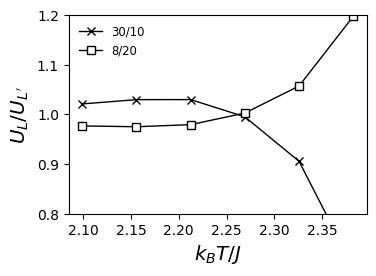

Critical temperature: 2.26


In [17]:
PyPlot.rc("figure", figsize = (7,5))

subplot(222)
plot(kT_vec[4:9], u4_rat1[4:9], lw=1, c="k", marker="x", ms=6, mfc="w", mec="k", label="30/10")
plot(kT_vec[4:9], u4_rat2[4:9], lw=1, c="k", marker="s", ms=6, mfc="w", mec="k", label="8/20")

ylim(0.8,1.2)
xlabel(L"k_BT/J", size="x-large")
ylabel(L"U_L/U_{L^\prime}", size="x-large")
legend(fontsize="small", loc="best", frameon=false);

tight_layout();

println("Critical temperature: 2.26")


Close to the transition point we expect to find the scaling relations

$$ m(T,L) = L^{-\beta/\nu} \hat{f}[(T-T_c)L^{1/\nu}], $$

$$ \chi(T,L) = L^{\gamma/\nu} \hat{g}[(T-T_c)L^{1/\nu}] .$$

In [18]:
ν = 1.0
β = 0.125
γ = 1.75

t_scaled = []
m_scaled = []
χ_scaled = []
for (L,m_vec,χ_vec) in zip(L_vec,m_L_vec, χ_L_vec)
    push!(t_scaled , [(kT - kT_crit)*L^(1/ν) for kT ∈ kT_vec])
    push!(m_scaled , [m*L^(β/ν) for m ∈ m_vec])
    push!(χ_scaled , [χ*L^(-γ/ν) for χ ∈ χ_vec])
end;

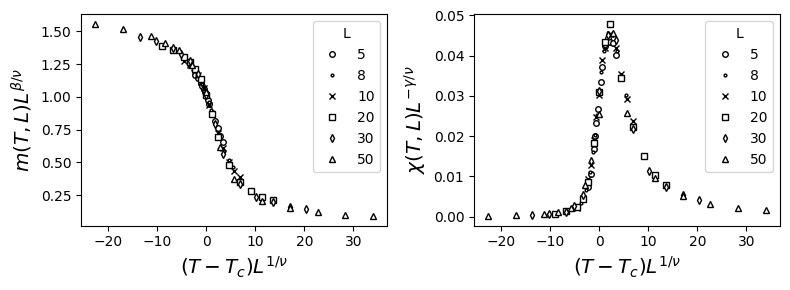

In [19]:
marker_list = ["o", ".", "x", "s", "d", "^"]
alpha_list = [0.4, 0.55, 0.7, 0.85, 1.0]

PyPlot.rc("figure", figsize = (8,3))

subplot(121)
i = 1
for (t,m) in zip(t_scaled, m_scaled)
    plot(t, m, lw=0, c="k", marker=marker_list[i], ms=4, mfc="w", mec="k", label=L_vec[i])
    i += 1
end

xlabel(L"$(T-T_c)L^{1/\nu}$", size="x-large")
ylabel(L"$m(T,L)L^{\beta/\nu}$", size="x-large")
legend(title="L")

subplot(122)
i = 1
for (t,χ) in zip(t_scaled, χ_scaled)
    plot(t, χ, lw=0, c="k", marker=marker_list[i], ms=4, mfc="w", mec="k", label=L_vec[i])
    i += 1
end

xlabel(L"$(T-T_c)L^{1/\nu}$", size="x-large")
ylabel(L"$χ(T,L)L^{-\gamma/\nu}$", size="x-large")
legend(title="L")

tight_layout();